# Strategy V4.2

In [53]:
from typing import Dict, List
from pandas import DataFrame, Series
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from numpy import ndarray
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score
import os
import joblib
import json
import matplotlib.pyplot as plt

instrument_nos: List[int] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17, 19, 
							 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 
							 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
RESPONSE_LOOKFORWARD: int = 10
RESPONSE_EMA_LOOKBACK: int = 7
commission_fee: float = 0.0005
CUTOFF: int = 60

In [54]:
# Get Data on Days 500 to 750 (Not used during training) but only trade from day 550 and onwards
def get_non_stationary_instruments() -> Dict[int, DataFrame]:
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", header=None, index_col=None)
	price_history: ndarray = raw_prices.values[:550][:].T
	
	data: Dict[int, DataFrame] = {}

	for instrument_no in instrument_nos:
		data[instrument_no] = pd.DataFrame(columns=["price"])
		data[instrument_no]["price"] = price_history[instrument_no]

	return data

def implement_rsi(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int]]) -> (
	Dict)[int, DataFrame]:
	for instrument_no in data:
		delta_prices: Series = data[instrument_no]["price"].diff()

		gains: Series= delta_prices.clip(lower=0)
		losses: Series = -delta_prices.clip(upper=0)

		avg_gain: Series = gains.rolling(window=params[instrument_no]["rsi_lookback"]).mean()
		avg_loss: Series = losses.rolling(window=params[instrument_no]["rsi_lookback"]).mean()

		relative_strength: Series = avg_gain / avg_loss
		relative_strength_index: Series = 100 - (100 / (1 + relative_strength))
		relative_strength_index.iloc[:params[instrument_no]["rsi_lookback"]] = 0.0
		data[instrument_no]["rsi"] = relative_strength_index

	return data

def implement_volatility(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int]]) -> (
	Dict)[int, DataFrame]:
	for instrument_no in data:
		prices_window: Series= data[instrument_no]["price"]
		returns: Series = prices_window.pct_change()
		volatility: Series = returns.rolling(window=params[instrument_no]["vol_lookback"]).std()
		data[instrument_no]["volatility"] = volatility.iloc[CUTOFF:]

	return data

# Positive: Slow EMA > Fast EMA - Bearish
# Negative: Slow EMA < Fast EMA - Bullish
def implement_ema_crossover(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int]]
) -> Dict[int, DataFrame]:
	for instrument_no in data:
		prices_window: Series = data[instrument_no]["price"]
		slow_lookback: int = params[instrument_no]["slow_ema_lookback"]
		fast_lookback: int = params[instrument_no]["fast_ema_lookback"]

		slow_ema: Series = prices_window.ewm(span=slow_lookback, adjust=False).mean()
		fast_ema: Series = prices_window.ewm(span=fast_lookback, adjust=False).mean()

		crossover_gap: Series = slow_ema - fast_ema
		crossover_gap.iloc[:slow_lookback] = 0.0
		data[instrument_no]["ema_crossover"] = crossover_gap

	return data

def implement_donchian_breakout(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int
]]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		lookback: int = params[instrument_no]["db_lookback"]
		# Assign upper and lower band
		upper: Series = data[instrument_no]["price"].rolling(window=lookback- 1).max().shift(1)
		lower: Series = data[instrument_no]["price"].rolling(window=lookback-1).min().shift(1)

		# Assign signals
		data[instrument_no]["db_signal"] = 0
		data[instrument_no].loc[data[instrument_no]["price"] > upper, 'db_signal']	= 1
		data[instrument_no].loc[data[instrument_no]["price"] < lower, 'db_signal']	= -1
		data[instrument_no]["db_signal"] = data[instrument_no]["db_signal"].ffill()

	return data

def setup_data(params: Dict[int, Dict[str, float | int]]) -> Dict[int, DataFrame]:
	data: Dict[int, DataFrame] = get_non_stationary_instruments()
	data = implement_rsi(data, params)
	data = implement_volatility(data, params)
	data = implement_ema_crossover(data, params)
	data = implement_donchian_breakout(data, params)

	for instrument_no in data: data[instrument_no] = (data[instrument_no]
													  .iloc[CUTOFF:].reset_index(drop=True))
	return data



### Testing Out of Sample Performance

In [55]:
def load_models() -> Dict[int, Dict[str, any]]:
	instruments_to_trade: List[int] = list(get_non_stationary_instruments().keys())
	models: Dict[int, Dict[str, any]] = {
		instrument_no: {} for instrument_no in instruments_to_trade
	}
	
	for instrument_no in instruments_to_trade:
		entry = joblib.load(f"models/logistic_regression_inst_{instrument_no}.pkl")
		scaler = entry["scaler"]
		model = entry["model"]
		models[instrument_no]["scaler"] = scaler
		models[instrument_no]["model"] = model
	
	return models

# Strategy Function
def get_strategy_signals() -> Dict[int, DataFrame]:
	models: Dict[int, Dict[str, any]] = load_models()
	
	config: Dict[str, Dict[str, any]]
	with open("config.json", "r") as configFile:
		config: Dict[str, Dict[str, any]] = json.load(configFile)
		
	params: Dict[int, Dict[str, float | int]] = {
		instrument_no: {
			"rsi_lookback": config[str(instrument_no)]["params"]["rsi_lookback"],
			"vol_lookback": config[str(instrument_no)]["params"]["vol_lookback"],
			"fast_ema_lookback": config[str(instrument_no)]["params"]["fast_ema_lookback"],
			"slow_ema_lookback": config[str(instrument_no)]["params"]["slow_ema_lookback"],
			"db_lookback": config[str(instrument_no)]["params"]["db_lookback"]
		} for instrument_no in get_non_stationary_instruments()
	}
	data: Dict[int, DataFrame] = setup_data(params)
	
	for instrument_no in data:
		# Get predictions over data using logistic regression model
		scaler = models[instrument_no]["scaler"]
		model = models[instrument_no]["model"]
		
		predictors = data[instrument_no].drop(columns=["price"], axis=1).values
		
		scaled_predictors = scaler.transform(predictors)
		signals = model.predict(scaled_predictors)
		signals[signals == 0] = -1
		data[instrument_no]["signal"] = signals
	
	return data

### Backtesting

In [56]:
def get_strategy_results(data: Dict[int, DataFrame]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		# Get Log Returns
		data[instrument_no]["log_return"] = np.log(data[instrument_no]
		["price"]).diff().shift(-1)

		# Get Strategy Return
		data[instrument_no]["strategy_return"] = (data[instrument_no]["signal"]
														   * data[instrument_no]["log_return"])

		# Get Position changes
		position_change: ndarray = data[instrument_no]["signal"].diff().abs()

		# Apply the commission fee
		data[instrument_no]["strategy_return"] -= position_change * commission_fee


	return data

def show_performance_metrics(data: Dict[int, DataFrame]) -> None:
	performance_metrics: Dict[str, List[int | float]] = {}
	performance_metrics["Instrument No."] = list(data.keys())
	performance_metrics["Profit Factor"] = []
	performance_metrics["Sharpe Ratio"] = []

	for instrument_no in data:
		# Get Returns
		returns: Series = data[instrument_no]["strategy_return"]

		# Compute performance metrics
		profit_factor = returns[returns > 0].sum() / returns[returns < 0].abs().sum()
		sharpe = (returns.mean() / returns.std()) * (252 ** 0.5)

		performance_metrics["Profit Factor"].append(profit_factor)
		performance_metrics["Sharpe Ratio"].append(sharpe)

	performance_metrics_df: DataFrame = pd.DataFrame(performance_metrics)
	print(performance_metrics_df.to_string(index=False))
		


### Performance Metrics

 Instrument No.  Profit Factor  Sharpe Ratio
              0       1.203779      1.178354
              1       0.886104     -0.772623
              2       1.019499      0.124072
              3       0.815355     -1.280008
              4       0.987253     -0.079367
              5       1.068139      0.419766
              6       1.315230      1.724194
              7       0.943644     -0.362362
              8       1.089199      0.549325
              9       1.100561      0.589953
             10       1.058285      0.351554
             11       1.192284      1.112631
             12       1.103719      0.622333
             13       1.143618      0.859622
             14       1.223823      1.290591
             15       0.963237     -0.233869
             16       1.008759      0.055531
             17       1.083642      0.510454
             19       1.169111      0.981443
             20       1.170550      1.001094
             21       0.904485     -0.645171
          

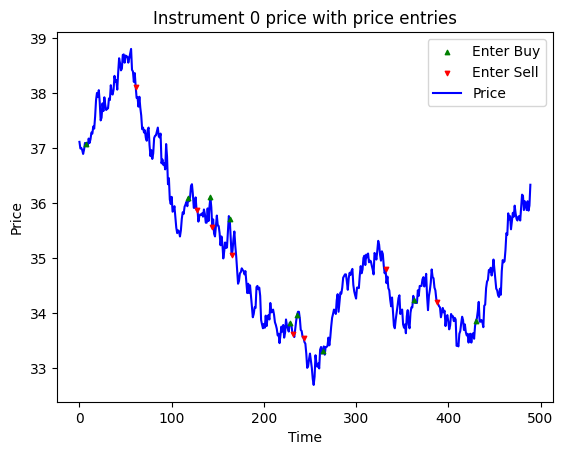

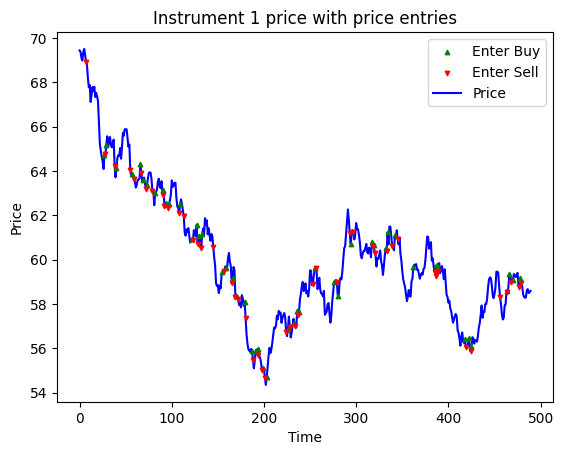

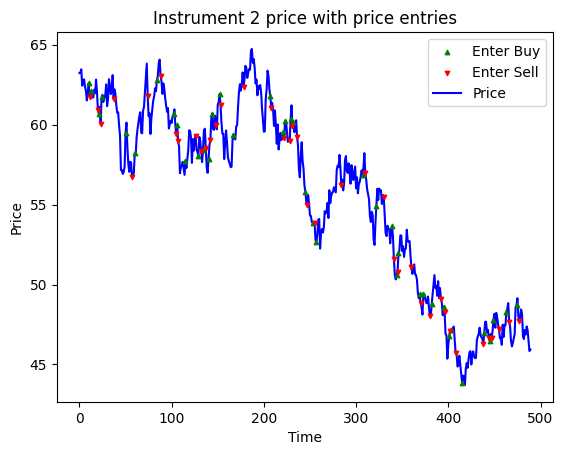

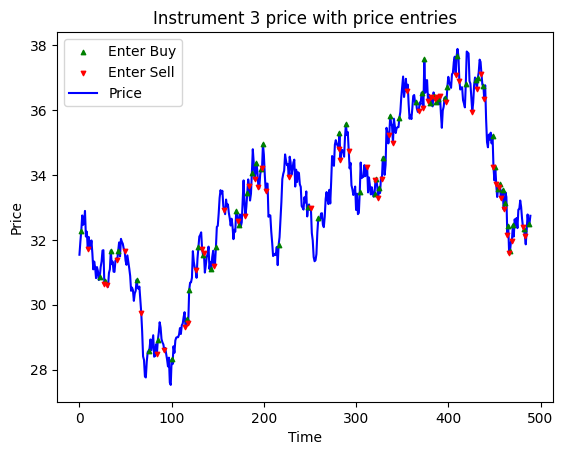

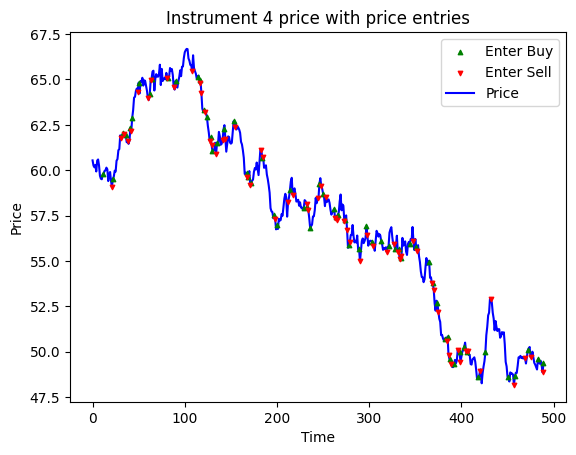

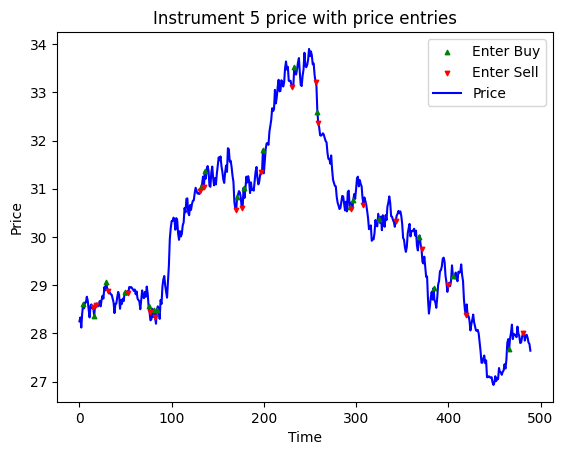

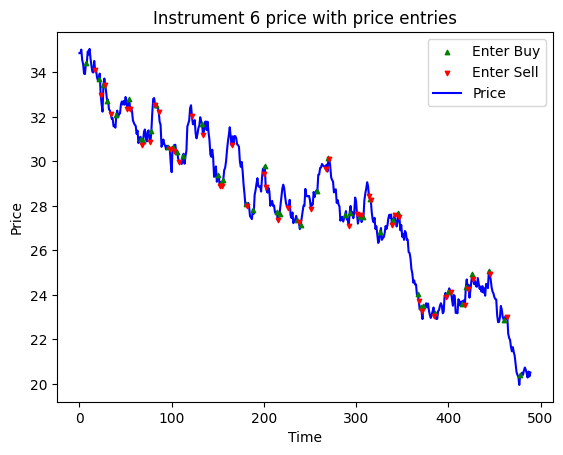

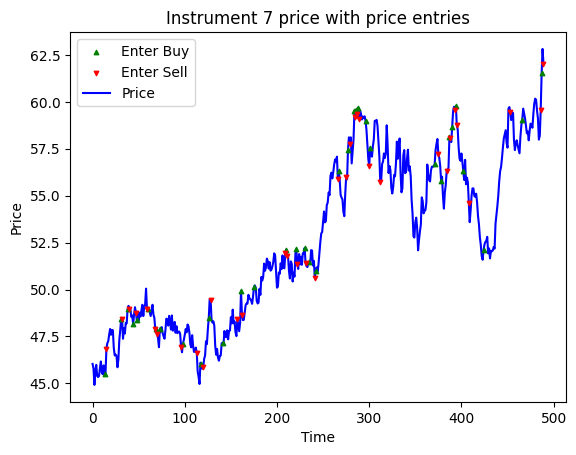

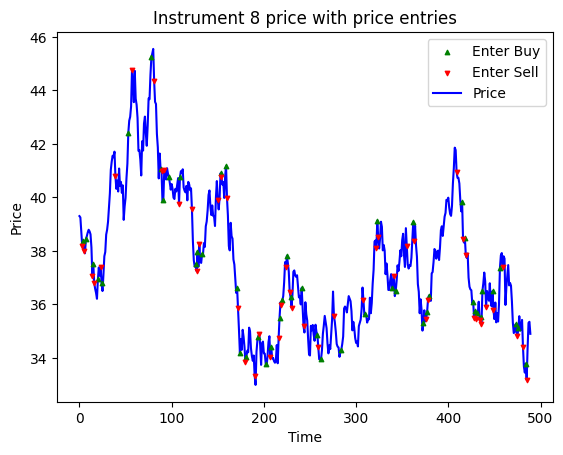

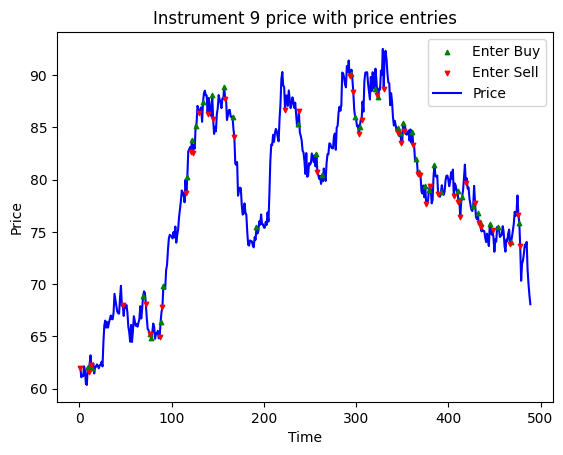

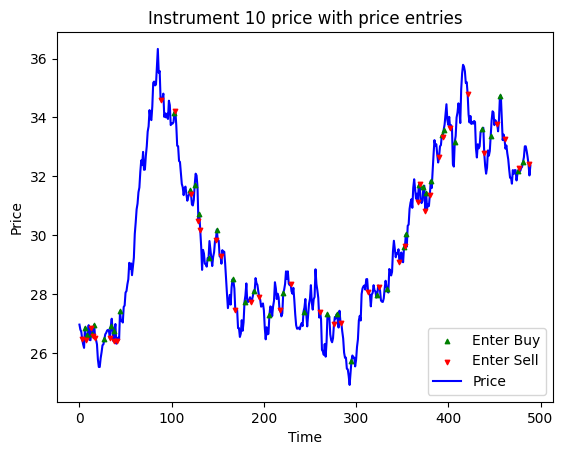

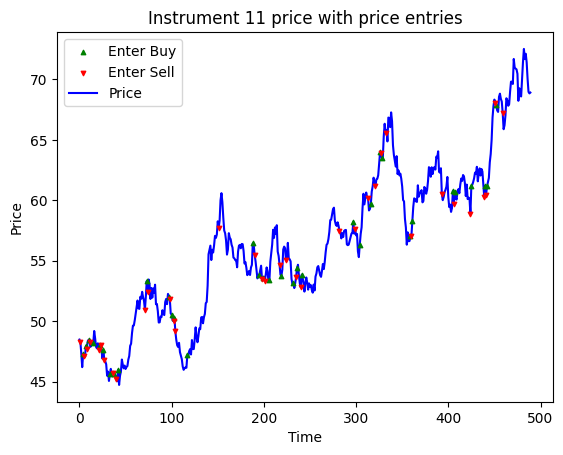

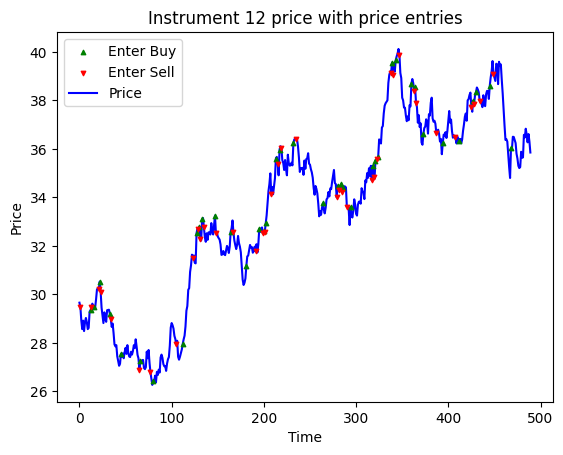

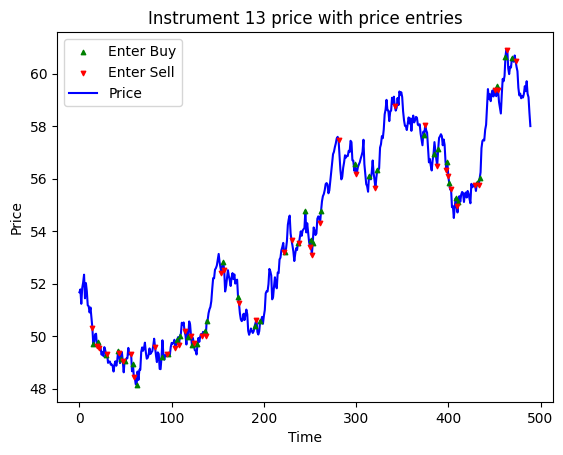

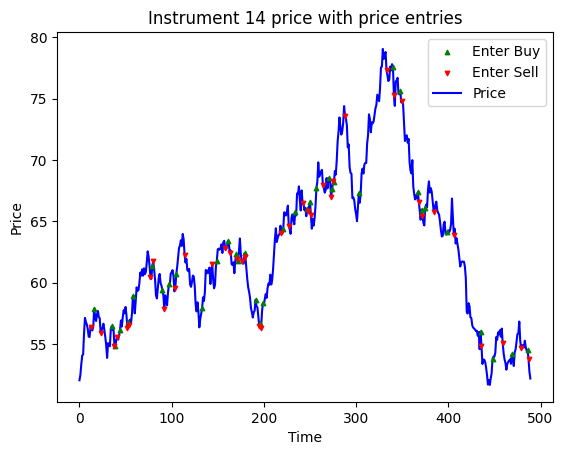

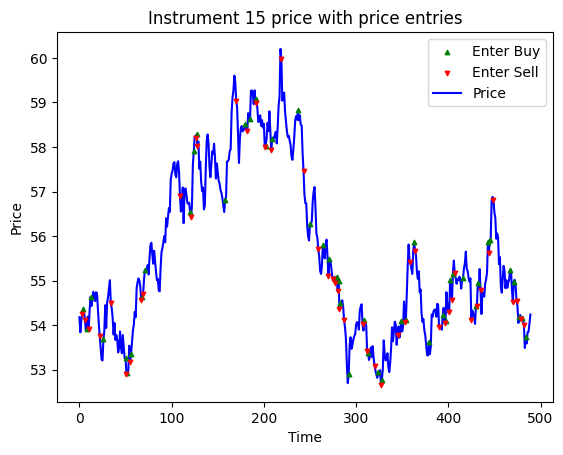

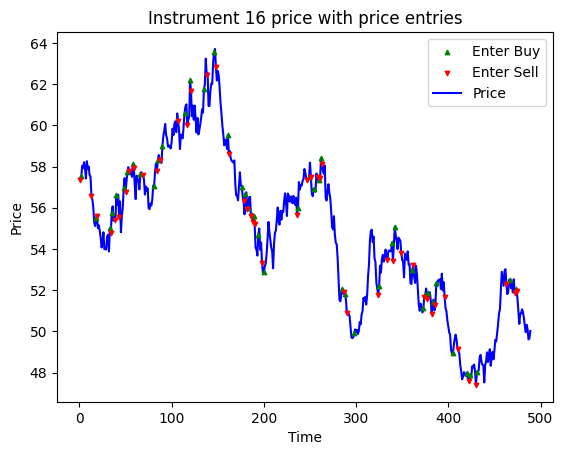

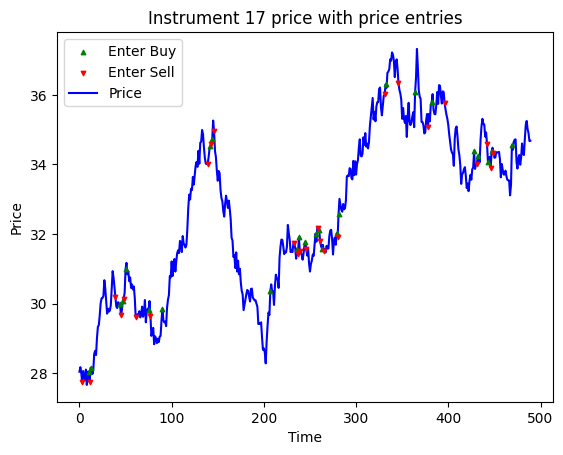

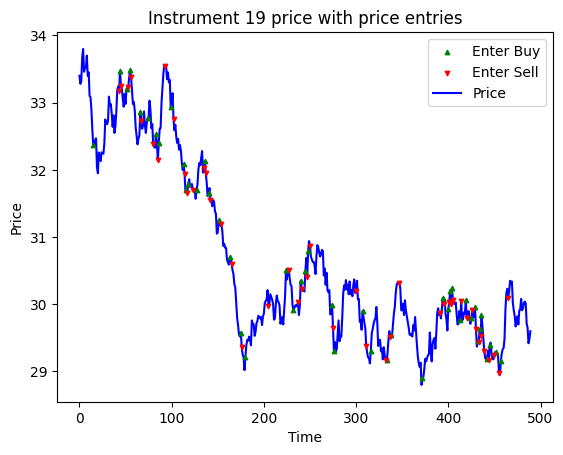

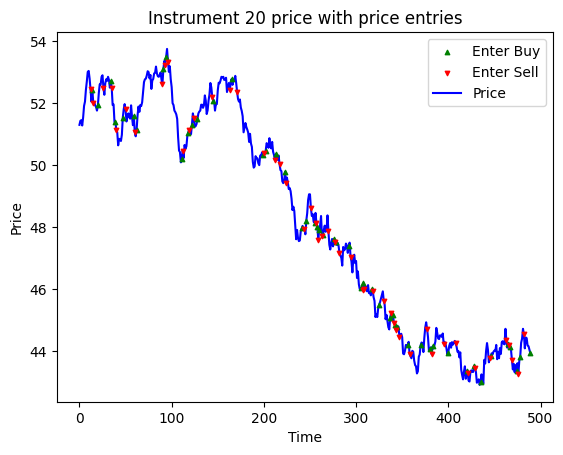

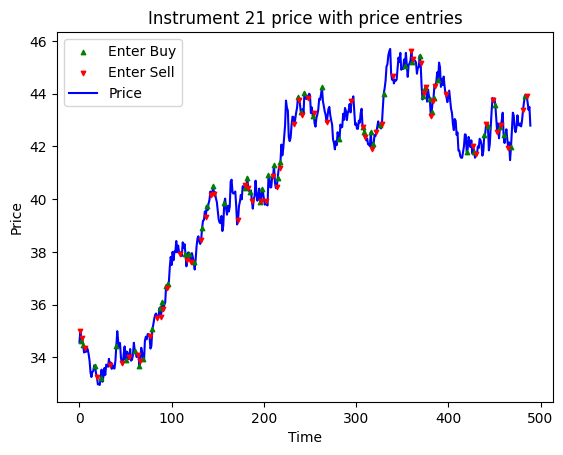

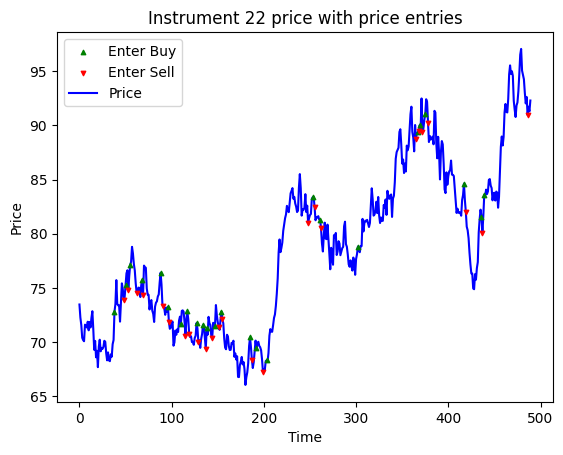

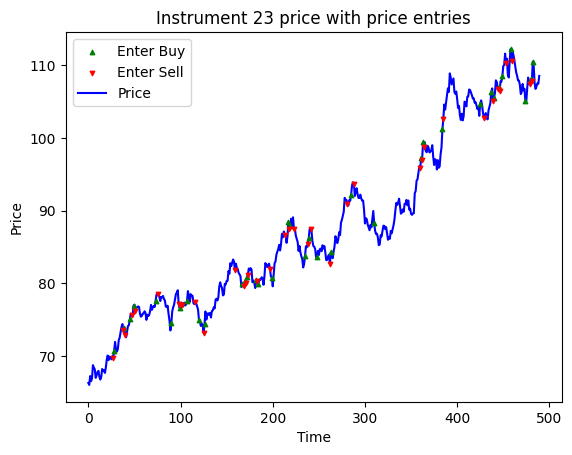

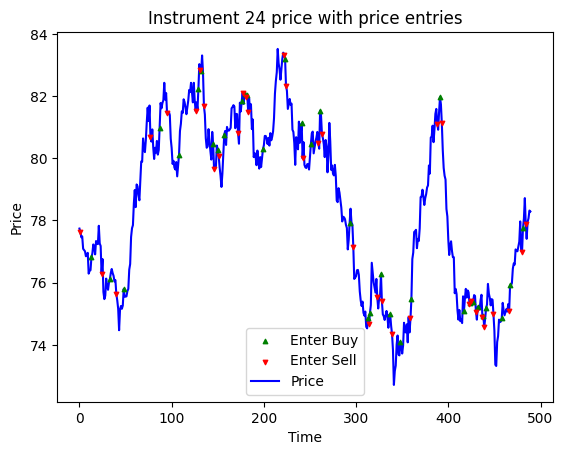

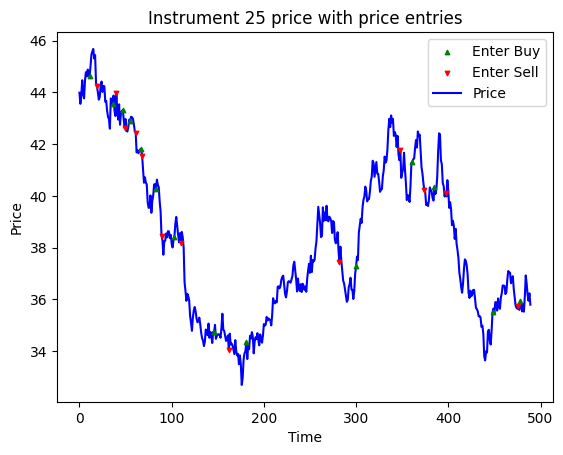

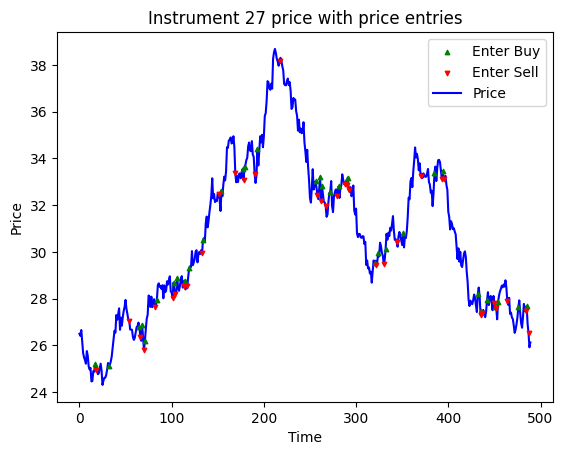

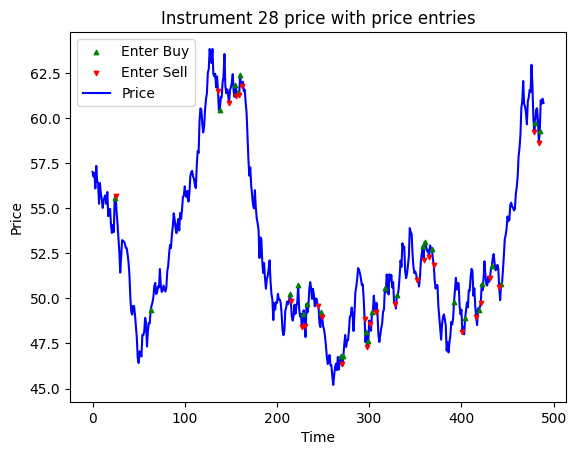

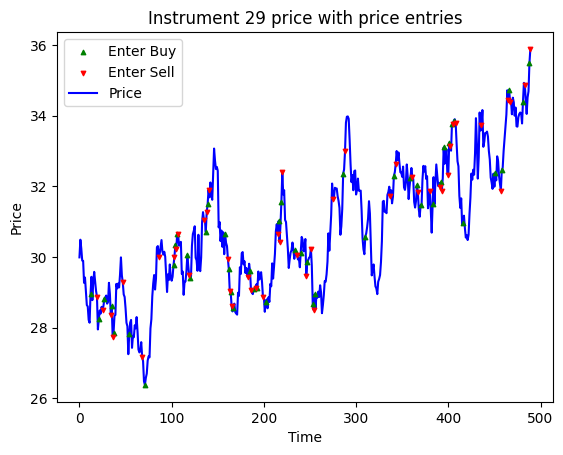

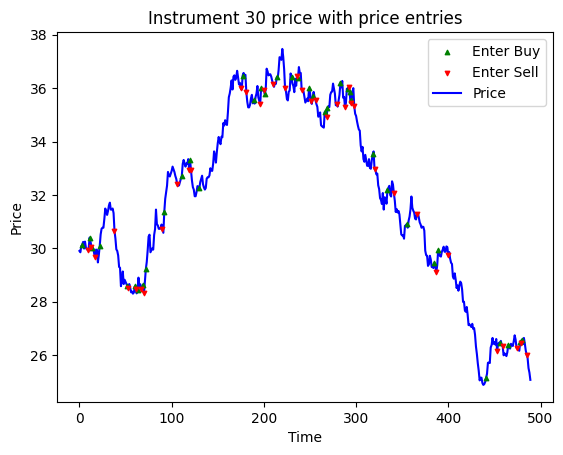

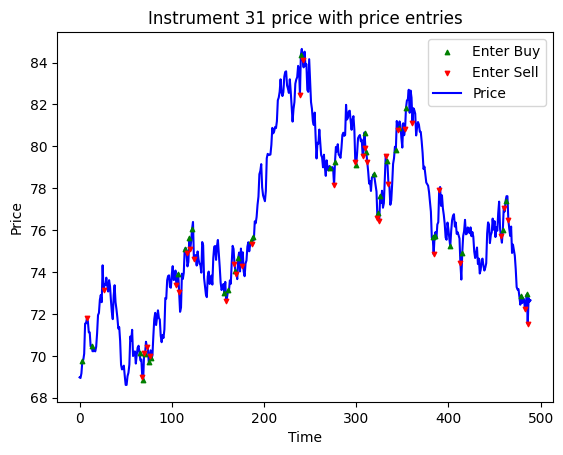

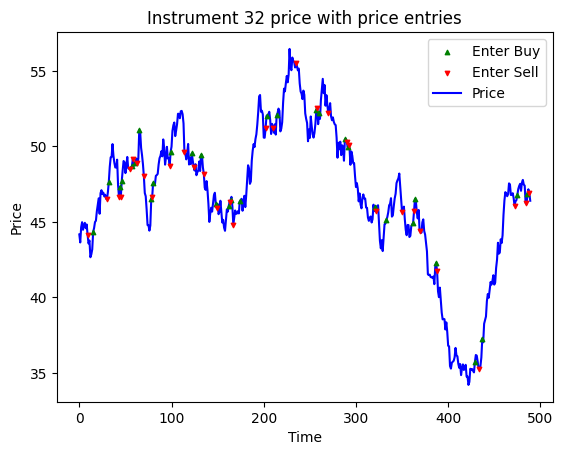

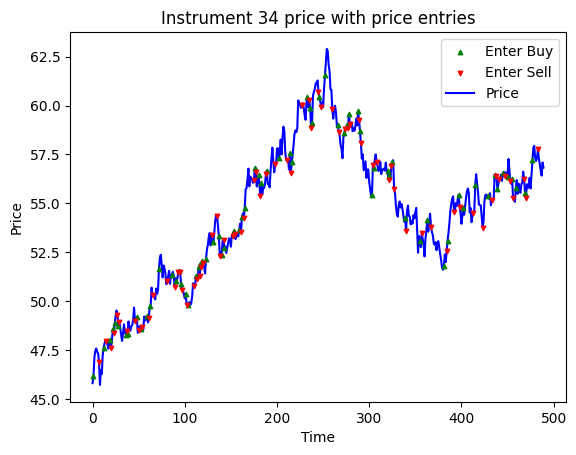

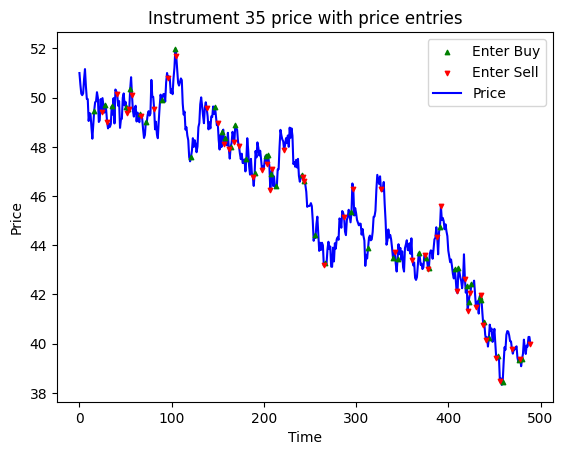

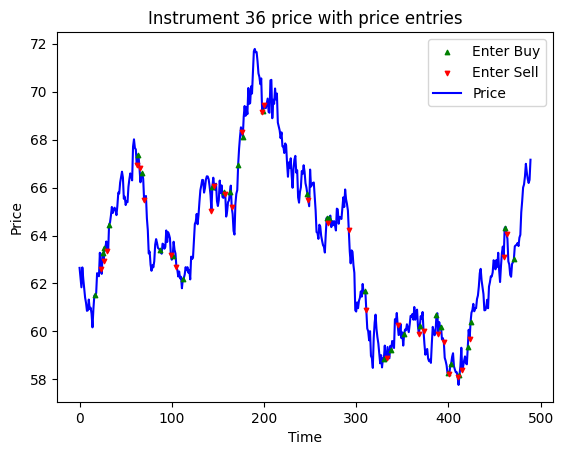

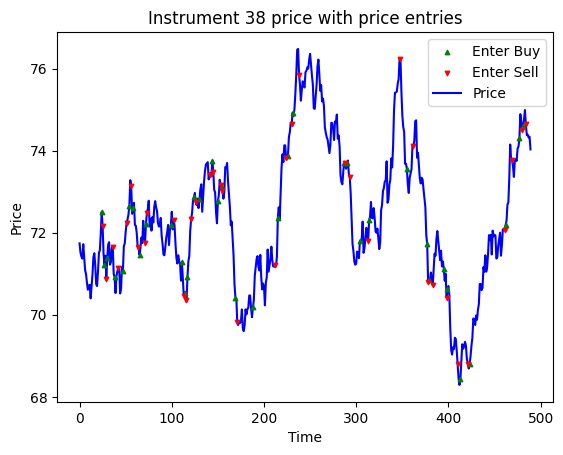

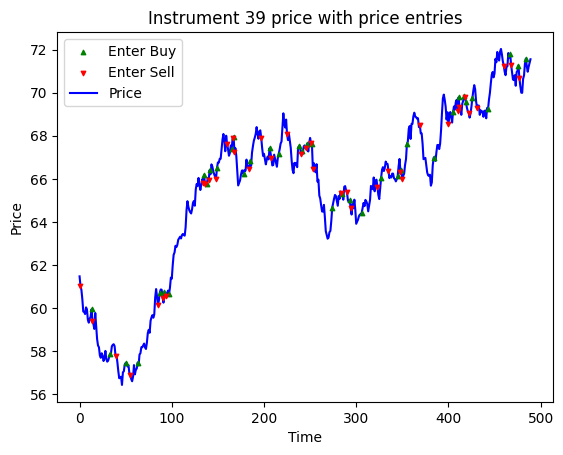

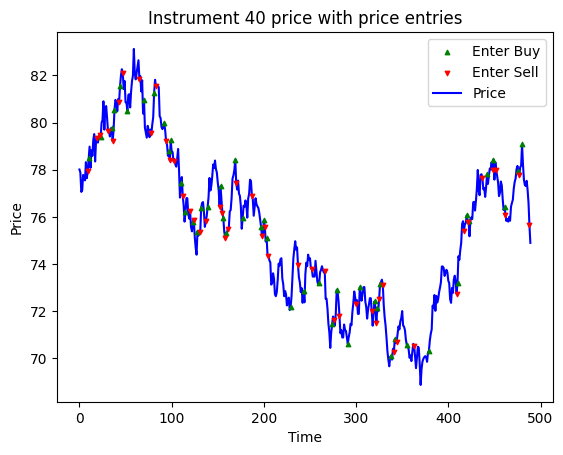

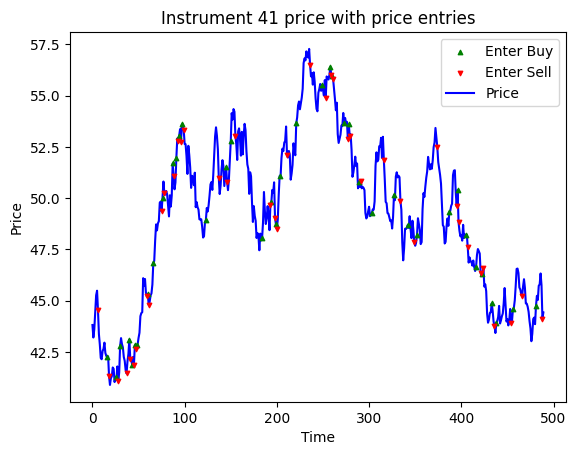

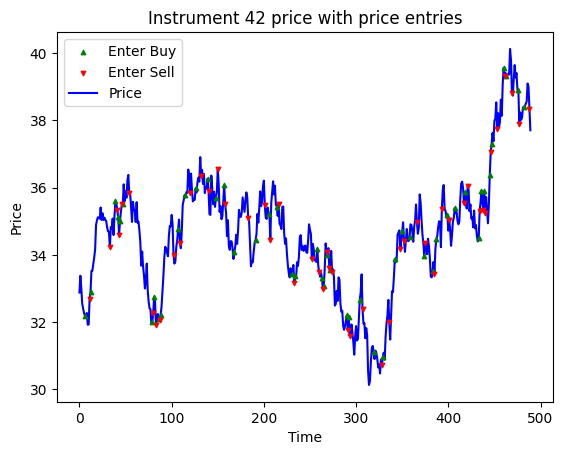

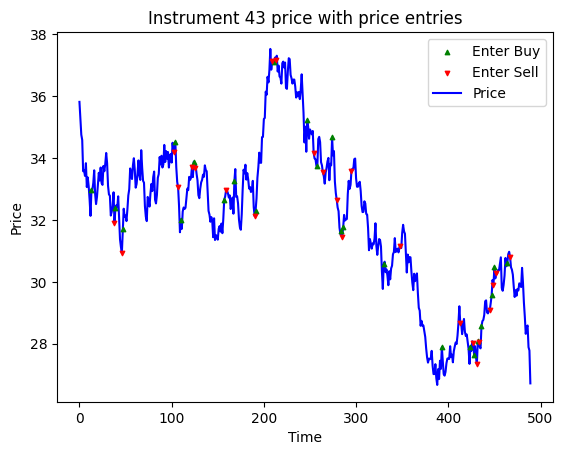

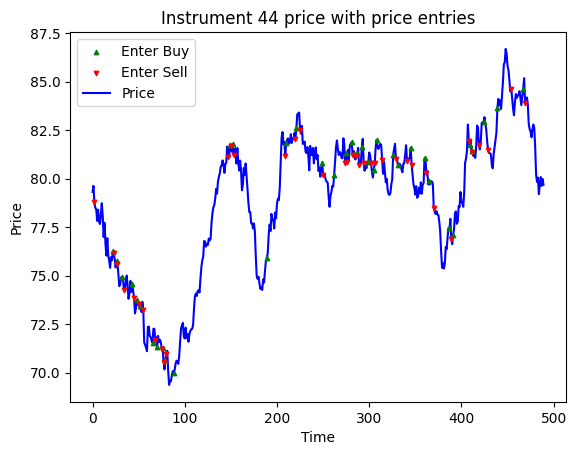

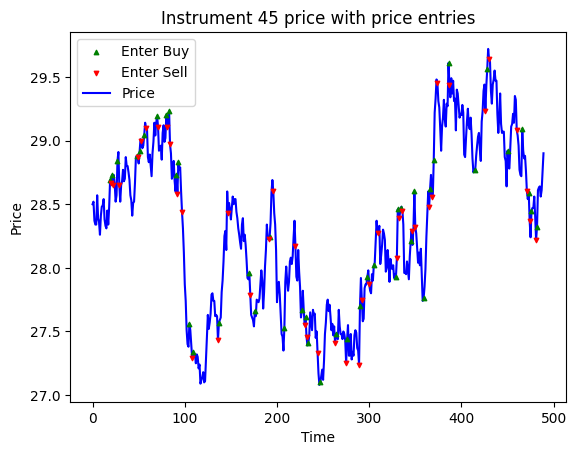

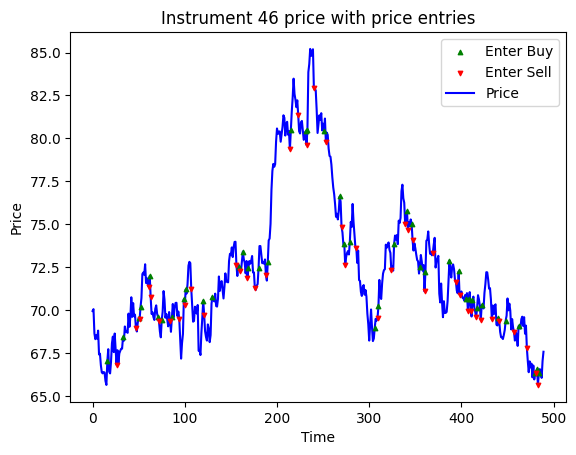

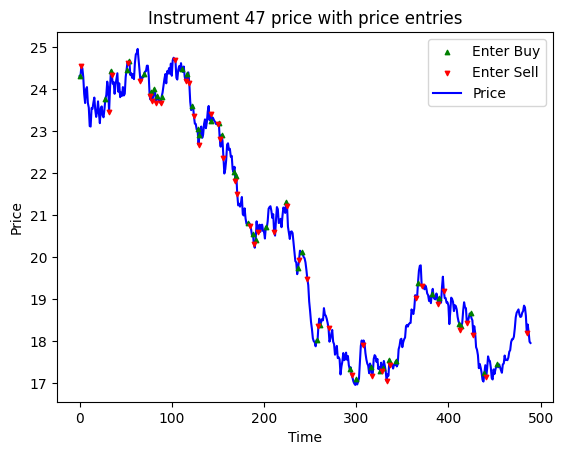

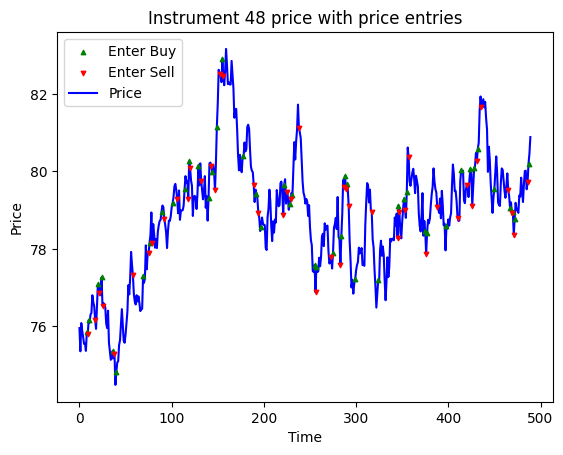

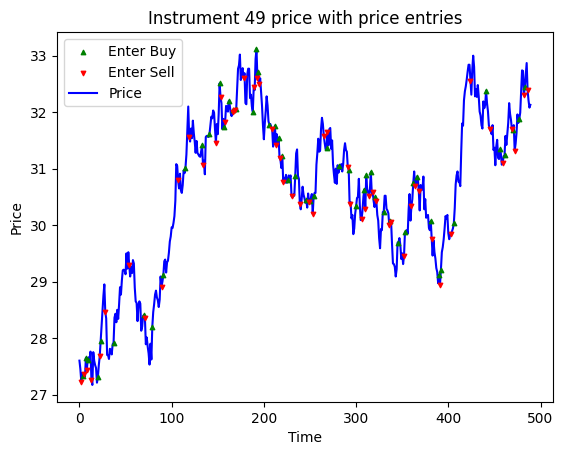

In [57]:
def show_price_entries(data: Dict[int, DataFrame]) -> None:
	for instrument_no in data:
		price: Series = data[instrument_no]["price"]
		signal: Series = data[instrument_no]["signal"]

		# Identify transitions (signal change)
		transitions = (signal != signal.shift())
		transitions.iloc[0] = False  # ignore first row
		
		up_points = data[instrument_no].index[transitions & (signal == 1)]
		down_points = data[instrument_no].index[transitions & (signal == -1)]
		
		plt.figure()
		plt.scatter(up_points, price.loc[up_points], marker='^', label='Enter Buy', s=10, 
			color="green", zorder=3)
		plt.scatter(down_points, price.loc[down_points], marker='v', label='Enter Sell', s=10, 
			color="red", zorder=3)
		plt.plot(price, color="blue", label="Price", zorder=1)
		plt.xlabel("Time")
		plt.ylabel("Price")
		plt.title(f"Instrument {instrument_no} price with price entries")
		plt.legend()
		plt.show()

data: Dict[int, DataFrame] = get_strategy_signals()
data = get_strategy_results(data)
show_performance_metrics(data)
show_price_entries(data)